**Chapter 3 – Classification**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/HOGENT-ML/course/blob/main/030-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Setup

In [1]:
# Python ≥3.11 is required
import sys
assert sys.version_info >= (3, 11)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥1.0.1 is required
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# MNIST
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and
employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the
“hello world” of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on
MNIST. 

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [3]:
# data type of MNIST dataset
print(type(mnist))

<class 'sklearn.utils._bunch.Bunch'>


In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

In [9]:
28 * 28

784

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one
pixel’s intensity, from 0 (white) to 255 (black). Let's have a look at one digit. 

In [10]:
np.set_printoptions(linewidth=400)
X[0].reshape(28,28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 225, 172

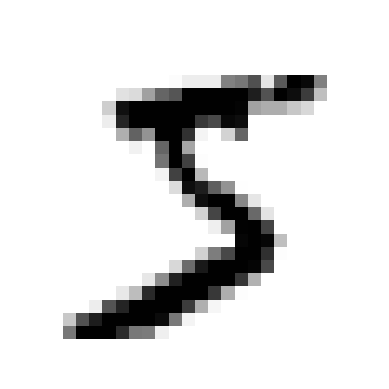

In [11]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [12]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [13]:
y = y.astype(np.uint8)

In [14]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

To give you a feel for the complexity of the classification task, next figure shows a few more images from the MNIST dataset.

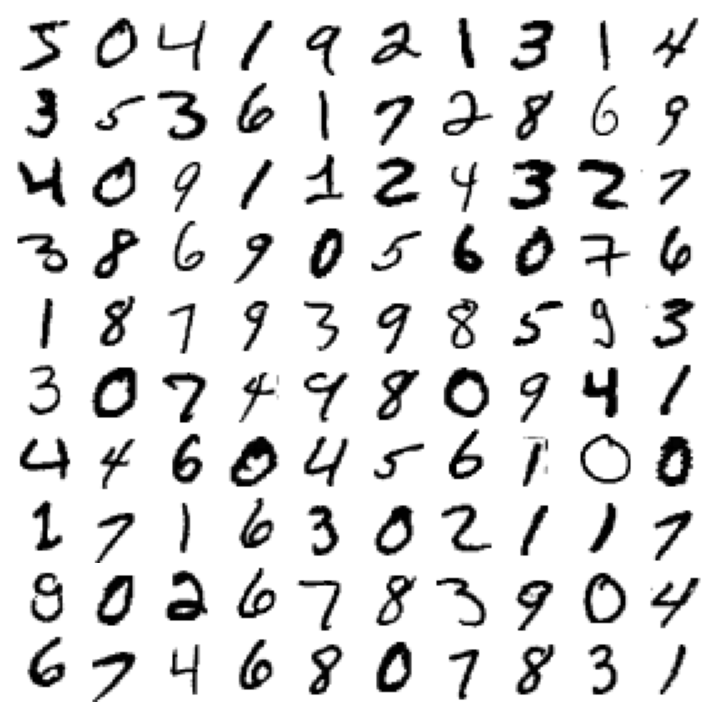

In [15]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split
into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want
one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly
if they get many similar instances in a row.

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a _binary
classifier_, capable of distinguishing between just two classes, 5 and not-5.

In [17]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent_ (SGD) classifier, using Scikit-Learn’s
`SGDClassifier` class. This classifier has the advantage of being **capable of handling very large datasets efficiently**. This is in part because SGD
deals with training instances independently, one at a time, which also makes SGD well suited for online learning.   

We explore the _Stochastic Gradient Descent_ (SGD) classifier in more detail in Chapter 4. 

Let’s create an `SGDClassifier` and train it on the whole training set:

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**TIP**  
The `SGDClassifier` relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state
parameter.

In [19]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s
performance.

# Performance Measures

## Measuring Accuracy Using Cross-Validation

Let’s use the `cross_val_score()` function to evaluate our SGDClassifier model, using K-fold cross-validation with three folds.
Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating
them on each fold using a model trained on the remaining folds (see Chapter 2):

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all crossvalidation folds? This looks amazing, doesn’t it? Well, before you get too
excited, let’s look at a a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [21]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # True if there is at least one "True"

False


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5,
you will be right about 90% of the time.  

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with
_skewed datasets_ (i.e., when some classes are much more frequent than others).

**Warning**: this output (and many others in this notebook and other notebooks) may differ slightly from those in the book. Don't worry, that's okay! There are several reasons for this:
* first, Scikit-Learn and other libraries evolve, and algorithms get tweaked a bit, which may change the exact result you get. If you use the latest Scikit-Learn version (and in general, you really should), you probably won't be using the exact same version I used when I wrote the book or this notebook, hence the difference. I try to keep this notebook reasonably up to date, but I can't change the numbers on the pages in your copy of the book.
* second, many training algorithms are stochastic, meaning they rely on randomness. In principle, it's possible to get consistent outputs from a random number generator by setting the seed from which it generates the pseudo-random numbers (which is why you will see `random_state=42` or `np.random.seed(42)` pretty often). However, sometimes this does not suffice due to the other factors listed here.
* third, if the training algorithm runs across multiple threads (as do some algorithms implemented in C) or across multiple processes (e.g., when using the `n_jobs` argument), then the precise order in which operations will run is not always guaranteed, and thus the exact result may vary slightly.
* lastly, other things may prevent perfect reproducibility, such as Python dicts and sets whose order is not guaranteed to be stable across sessions, or the order of files in a directory which is also not guaranteed.

## Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B.  In general, this is a much better way to evaluate the performance of a classifier.  

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. 

Since we don't touch the test set untill the very end of the project, we can use `cross_val_predict()` instead. 

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

- Each _row_ in a confusion matrix represents an _actual class_
- Each _column_ represents a _predicted class_.  
- The first row of this matrix considers non-5 images: the _negative class_
    - 53.892 of them were correctly classified as non-5s: _true negatives_
    - the remaining 687 were wrongly classified as 5s: _false positives_
- The second row considers the images of 5s: the _positive class_ 
    - 1891 were wrongly classified as non-5s: _false negatives_
    - the remaining 3530 were correctly classified as 5s: _true positives_

A perfect classifier would have only true positives (TP) and true negatives (TN), so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [25]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall
- The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the _precision_ of the classifier.   

- _precision_ : the proportion of all samples that were predicted as positive which are really positive
$$    
P = \frac{TP}{TP + FP}
$$ 
A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this
would not be very useful, since the classifier would ignore all but one positive instance. 

So precision is typically used along with another metric
named _recall_, also called _sensitivity_ or the _true positive rate_ (TPR)
     
- _recall_ : the proportion of all positives which are correctly predicted
$$    
R = \frac{TP}{TP + FN}
$$

![](img/confmatrix.png)

In [26]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [27]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [29]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. 

Moreover, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the _F<sub>1</sub> score_, in particular if you need a simple way to compare two classifiers.

$$
F_1 = 2\frac{P \cdot R}{P + R}
$$

The classifier will only get a high F<sub>1</sub> score score if both recall and precision are high.

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

## Precision/Recall Trade-off

The _F<sub>1</sub> score_ favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.

For example:
- if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your
product. 
- suppose you train a classifier to detect shoplifters in surveillance images: it is probably
fine if your classifier has only 30% precision as long as it has 99% recall
(sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. 
- It computes a score based on a _decision function_. 
- If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

![](img/precision-recall.png)

### Exercise ###

In an article on the website of the U.S. Food and Drug Administration agency (
See https://www.fda.gov/medical-devices/safety-communications/home-covid-19-antigen-tests-take-steps-reduce-your-risk-false-negative-results-fda-safety#:~:text=Molecular%20COVID%2D19%20tests%20are,time%20when%20someone%20is%20infected) we found following claim:  

**Overall performance of at-home COVID-19 antigen tests**  
Most at-home COVID-19 tests are antigen tests and do not detect the SARS-CoV-2 virus as well as molecular tests, most of which are laboratory-based such as polymerase chain reaction (PCR) tests. Molecular COVID-19 tests are generally expected to detect the SARS-CoV-2 virus at least 95% of the time when someone is infected. However, at-home COVID-19 antigen tests are generally expected to detect the SARS-CoV-2 virus at least 80% of the time when someone is infected.

When you perform an at-home COVID-19 antigen test, and you get a positive result, the results are usually accurate. However, if you perform an at-home COVID-19 antigen test, you could get a false negative result. This means that the test may not detect the SARS-CoV-2 virus that is in your nasal swab sample. This could happen if you test soon after you get an infection, especially if you don't have COVID-19 symptoms. If you receive a false negative test result, you may unknowingly spread the SARS-CoV-2 virus to others.

**Questions**

- _What are the precision and recall for at-home COVID-19 antigen tests?_
- What is more important if you want to prevent spreading the infection: precision or recall? 





# The ROC Curve

- The _receiver operating characteristic_ (ROC) curve is common tool used with binary classifiers.
- It plots the _true positive rate_ (TPR, another name for recall) against the _false positive rate_ (FPR) for various threshold values.
- The FPR (also called the _fall-out_) is the ratio of negative instances that are incorrectly classified as positive. 
- It is equal to 1 – the _true negative rate (TNR)_, which is the ratio of negative instances that are correctly classified as negative. 
- The TNR is also called _specificity_. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.
- To plot the ROC curve, we first use the `roc_curve()` function to compute the TPR and FPR for various threshold values.
- We can use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time we specify that we want to get the decision scores instead of predictions:

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [34]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,  13272.12718981,  -7258.47203373, -16877.50840447])

In [35]:
len(y_scores)

60000

In [36]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.         ... 0.99937705 0.99937705 1.        ]
[0.00000000e+00 1.84467810e-04 9.22339052e-04 ... 9.99815532e-01 1.00000000e+00 1.00000000e+00]
[             inf   49441.43765905   36801.60697028 ... -105763.22240074 -106527.45300471 -146348.56726174]


In [37]:
len(thresholds)

3908

- Now we can plot the FPR against the TPR using Matplotlib. 
- To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. 
- Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

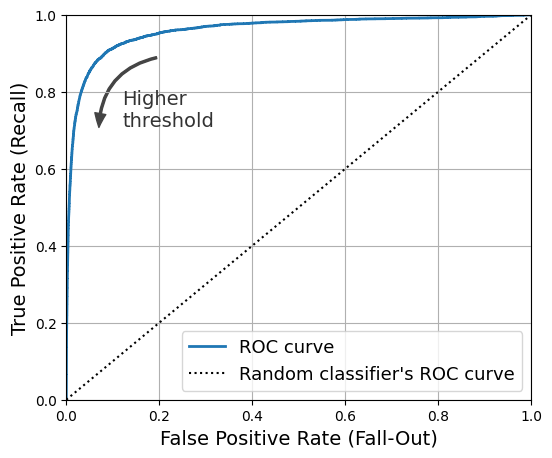

In [38]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

# extra code – just beautifies the figure with the curved arrow
plt.gca().add_patch(patches.FancyArrowPatch(
     (0.20, 0.89), (0.07, 0.70),
     connectionstyle="arc3,rad=.4",
     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
     color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

- Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces.  
- The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
- One way to compare classifiers is to measure the area under the curve (AUC). 
- A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5- Scikit-Learn provides a function to estimate the ROC AUC:

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a `RandomForestClassifier`, to compare the AUC with the the `SGDClassifier`:

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

**Warning:** the following cell may take a few minutes to run.

- But the `RandomForestClassifier` class does not have a `decision_function()` method, due to the way it works (we will cover this in Chapter 7). 
- Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine

In [41]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let’s look at the class probabilities for the first two images in the training set:

In [42]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it
predicts that the second image is negative with 99% probability. Since each image is
either positive or negative, the probabilities in each row add up to 100%.  

The second column contains the estimated probabilities for the positive class, so we can use it as the scores to calculate the AUC: 

In [43]:
y_scores_forest = y_probas_forest[:, 1]
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The ROC AUC score for the `RandomForestClassifier` is significantly better than for the `SGDClassifier`. 

# Multiclass Classification

_Multiclass classifiers_ (also called _multinomial classifiers_) can distinguish between more than two classes. 

- Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively.
- Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. 
- However, there are various strategies that you can use to perform multiclass classification (classify the digit images into 10 classes (from 0 to 9)   with multiple binary classifiers.
    - _one-versus-the-rest (OvR)_ or _one versus-all_:  train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. 
    - _one-versus-one (OvO)_: train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, etc. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. __The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.__

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is
preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary
classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the `sklearn.svm.SVC` class. 

We’ll only train on the first 2,000 images, or else it will take a very long time:

In [44]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [45]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- This code trains the SVC on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the rest target classes (y_train_5). 
- Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

Training an SGDClassifier (or a RandomForestClassifier) on a multiclass dataset and using it to make predictions isjust as easy:

In [46]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- Oops, that’s incorrect. Prediction errors do happen! 
- This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers.

To evaluate this classifier, you can use cross-validation. Use the `cross_val_score()` function to evaluate the SGDClassifier’s accuracy:

**Warning**: the following cell may take close to 30 minutes to run, or more depending on your hardware.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 85% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still
do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

- If this were a real project, you would now follow the steps we saw in chapter 2.
- You’d explore data preparation options, try out multiple models, shortlist the best ones, fine-tune their hyperparameters using GridSearchCV, and automate as much as possible. 
- Here, we will assume that you have found a promising model and you want to find ways to improve it. 
- One way to do this is to analyze the types of errors it makes.
- First, look at the confusion matrix.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]], dtype=int64)

A colored diagram of the confusion matrix is much easier to analyze. To plot such a
diagram, use the `ConfusionMatrixDisplay.from_predictions()` function like this:

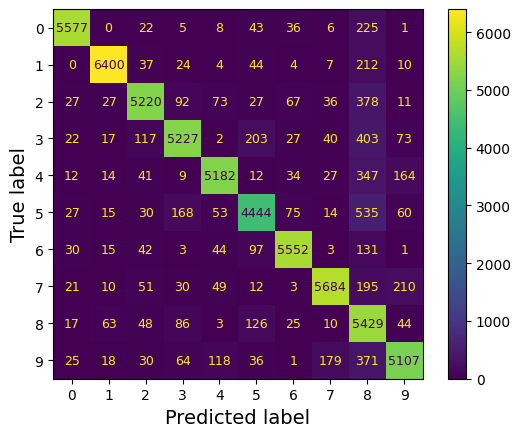

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

- This confusion matrix looks pretty good: most images are on the main diagonal, which means that they were classified correctly. 
- Notice that the cell on the diagonal in row #5 and column #5 looks slightly darker than the other digits. 
- This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. 
- That’s why it’s important to normalize the confusion matrix by dividing each value by the total
number of images in the corresponding (true) class (i.e., divide by the row’s sum).
- This can be done simply by setting `normalize="true"`. 
- We can also specify the `values_format=".0%"` argument to show percentages with no decimals.

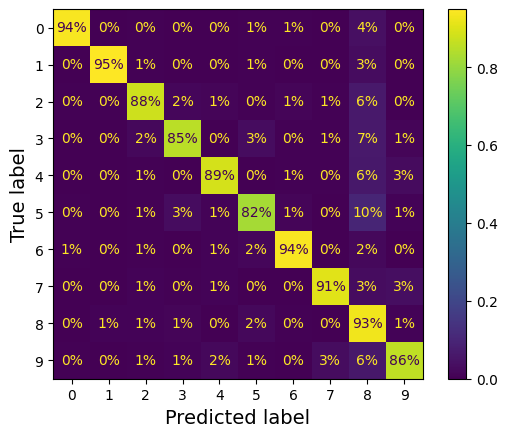

In [ ]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

- Now we can easily see that only 82% of the images of 5s were classified correctly. 
- The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. 
- But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrical!

Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. 
- try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. 
- engineer new features that would help the classifier
    - writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none)
- preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.